# Chess.com Reviews App Sentiment Analysis

Proyek ini berfokus pada analisis sentimen ulasan pengguna terhadap aplikasi Chess.com untuk memahami opini, tingkat kepuasan, dan area yang perlu ditingkatkan.

Proyek ini memiliki 4 skema pelatihan:
1. SVM, TF-IDF, 80/20
2. Random Forest, TF-IDF, 80/20
3. Logistic Regression, n-gram, 80/20
4. GRU, n-gram, 80/20

---

*Joshua Palti Sinaga | Proyek Analisis Sentimen Dicoding*

In [ ]:
!pip install google-play-scraper
!pip install beautifulsoup4
!pip install vaderSentiment
!pip install gensim
!pip install wordcloud

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.3 MB/s eta 0:00:00


In [ ]:
PACKAGE_NAME = 'com.chess'

# Data Scraping
Data yang digunakan untuk proyek sentiment analysis ini diambil dari ulasan aplikasi **Chess** pada platform **Google Play Store** dalam bahasa Inggris. Jumlah data yang di-scrape ada sekitar 20.000 data menggunakan library google-play-scraper dan sekitar 16.000 setelah data cleaning.

In [ ]:
from google_play_scraper import app

app_details = app(
    PACKAGE_NAME,
    lang='en',
    country='us'
)

print(f"App ID: {app_details['title']}")
print(f"App Name: {app_details['appId']}")
print(f"App Developer: {app_details['developer']}")
print(f"App Summary: {app_details['summary']}")
print(f"App Installs: {app_details['installs']}")
print(f"App Reviews: {app_details['reviews']}")


App ID: Chess - Play and Learn
App Name: com.chess
App Developer: Chess.com
App Summary: Play chess online with friends! Learn with lessons, puzzles & analysis!
App Installs: 50,000,000+
App Reviews: 39347


In [ ]:
from google_play_scraper import Sort, reviews

SCRAPE_FROM_PLAY_STORE = False
count = 20000

if os.path.exists('chess.csv'):
  print("Dataset already downloaded, skipping...")
elif not SCRAPE_FROM_PLAY_STORE:
  print("Downloading dataset from Google Drive")
  !gdown 1sN-a1c4873Sd7MBBOypme0L0ynQnqKqw -O chess.csv
else:
  print(f'Scraping reviews from {PACKAGE_NAME} with {count} rows')
  result, continuation_token = reviews(
      PACKAGE_NAME,
      lang='en',
      country='us',
      sort=Sort.NEWEST,
      count=count,
  )
  result, _ = reviews(
      PACKAGE_NAME,
      continuation_token=continuation_token
  )

  import pandas as pd
  df = pd.DataFrame(result)
  df.to_csv('chess.csv', index=None, header=True)
  print('Review Scraping Done. Saved  as chess.csv')

Downloading...
From: https://drive.google.com/uc?id=1sN-a1c4873Sd7MBBOypme0L0ynQnqKqw
To: /content/chess.csv
100% 7.44M/7.44M [00:00<00:00, 34.5MB/s]


# Dataset Cleaning

In [ ]:
df = pd.read_csv('chess.csv')
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,5962950f-3e46-4c39-a6e2-8f106c74b698,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,Bal er game sala acc er username likhle ki sob...,1,0,NaN,2024-06-22 18:48:35,NaN,NaN,NaN
1,3449cc27-d298-42b5-ad4b-364875cc00fc,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,reallygoodgame👍👍i love it,5,0,4.6.26-googleplay,2024-06-22 18:40:21,NaN,NaN,4.6.26-googleplay
2,0346d15d-8ebc-4c6a-af8d-d85bf64f68b7,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,third class app...there is no even distributio...,1,1,4.6.27-googleplay,2024-06-22 18:25:59,Hello! While you might get a few games with wh...,2024-06-28 00:40:32,4.6.27-googleplay
3,89a05d89-d38e-401a-8b22-07950d43e276,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,Play chess at your level with people ALL over ...,5,0,4.6.27-googleplay,2024-06-22 17:51:20,NaN,NaN,4.6.27-googleplay
4,4dd12905-6dca-44e5-9d89-2cd79080af50,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,great app for chess players,5,0,4.6.26-googleplay,2024-06-22 17:43:43,NaN,NaN,4.6.26-googleplay


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              20000 non-null  object
 1   userName              20000 non-null  object
 2   userImage             20000 non-null  object
 3   content               20000 non-null  object
 4   score                 20000 non-null  int64 
 5   thumbsUpCount         20000 non-null  int64 
 6   reviewCreatedVersion  17196 non-null  object
 7   at                    20000 non-null  object
 8   replyContent          10408 non-null  object
 9   repliedAt             10408 non-null  object
 10  appVersion            17196 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.7+ MB


In [ ]:
# Mengambil kolom yang diperlukan berupa 'content', 'score'
df = df[['content', 'score']]
print(f'Baris, Kolom: {df.shape}')
df.head()

Baris, Kolom: (20000, 2)


,content,score
0,Bal er game sala acc er username likhle ki sob...,1
1,reallygoodgame👍👍i love it,5
2,third class app...there is no even distributio...,1
3,Play chess at your level with people ALL over ...,5
4,great app for chess players,5


In [ ]:
df = df.dropna()
print(f'Baris, Kolom: {df.shape}')
df.head()

Baris, Kolom: (20000, 2)


,content,score
0,Bal er game sala acc er username likhle ki sob...,1
1,reallygoodgame👍👍i love it,5
2,third class app...there is no even distributio...,1
3,Play chess at your level with people ALL over ...,5
4,great app for chess players,5


In [ ]:
df = df.drop_duplicates()
print(f'Baris, Kolom: {df.shape}')
df.head()

Baris, Kolom: (15925, 2)


,content,score
0,Bal er game sala acc er username likhle ki sob...,1
1,reallygoodgame👍👍i love it,5
2,third class app...there is no even distributio...,1
3,Play chess at your level with people ALL over ...,5
4,great app for chess players,5


# Exploratory Data Analysis

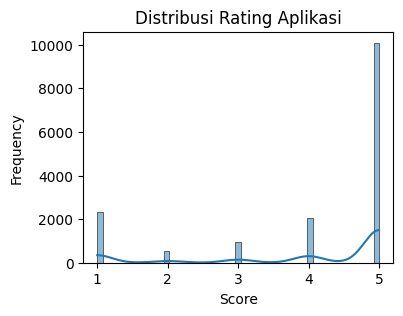

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(4, 3))
sns.histplot(df['score'], kde=True)
plt.title('Distribusi Rating Aplikasi')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

# Data Preprocessing

In [ ]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()
    # Remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    # Remove chars
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    text = re.sub(r'[ ]+', ' ', text)
    # Tokenization
    words = text.split()
    # Stopword Removal
    words = [word for word in words if word not in stop_words]
    # Lemmatization
    words = [lemmatizer.lemmatize(word) for word in words]
    text = ' '.join(words)
    return text

df['processed_content'] = df['content'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
<ipython-input-11-61a93bc5f632>:17: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15925 entries, 0 to 19999
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   content            15925 non-null  object
 1   score              15925 non-null  int64 
 2   processed_content  15925 non-null  object
dtypes: int64(1), object(2)
memory usage: 497.7+ KB


In [ ]:
df

,content,score,processed_content
0,Bal er game sala acc er username likhle ki sob...,1,bal er game sala acc er username likhle ki sob...
1,reallygoodgame👍👍i love it,5,reallygoodgame love
2,third class app...there is no even distributio...,1,third class app even distribution black white ...
3,Play chess at your level with people ALL over ...,5,play chess level people world
4,great app for chess players,5,great app chess player
...,...,...,...
19995,best chess website except for the fees to use ...,4,best chess website except fee use bot infinite...
19996,"Insensitive piece selection, you have to hit i...",2,insensitive piece selection hit right center m...
19997,This game is so sexy,5,game sexy
19998,The best in the world magnus gothom chess and ...,5,best world magnus gothom chess hikaru nakamura...


# Data Labelling (VADER Sentiment)

Data labelling dilakukan menggunakan **VADER (Valence Aware Dictionary and sEntiment Reasoner)** untuk setiap baris data yang sudah dilakukan preprocessing.

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def get_vader_sentiment(text):
    scores = analyzer.polarity_scores(text)
    compound_score = scores['compound']

    if compound_score >= 0.05:
        return 'positive'
    elif compound_score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

df['sentiment'] = df['processed_content'].apply(get_vader_sentiment)
df['sentimentInt'] = df['sentiment'].map({'positive': 2, 'neutral': 1, 'negative': 0})
df

,content,score,processed_content,sentiment,sentimentInt
0,Bal er game sala acc er username likhle ki sob...,1,bal er game sala acc er username likhle ki sob...,negative,0
1,reallygoodgame👍👍i love it,5,reallygoodgame love,positive,2
2,third class app...there is no even distributio...,1,third class app even distribution black white ...,negative,0
3,Play chess at your level with people ALL over ...,5,play chess level people world,positive,2
4,great app for chess players,5,great app chess player,positive,2
...,...,...,...,...,...
19995,best chess website except for the fees to use ...,4,best chess website except fee use bot infinite...,positive,2
19996,"Insensitive piece selection, you have to hit i...",2,insensitive piece selection hit right center m...,positive,2
19997,This game is so sexy,5,game sexy,positive,2
19998,The best in the world magnus gothom chess and ...,5,best world magnus gothom chess hikaru nakamura...,positive,2


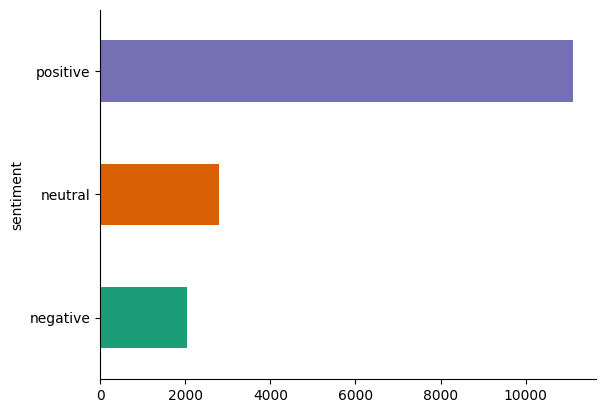

In [ ]:
# @title Sentiment Distribution

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('sentiment').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

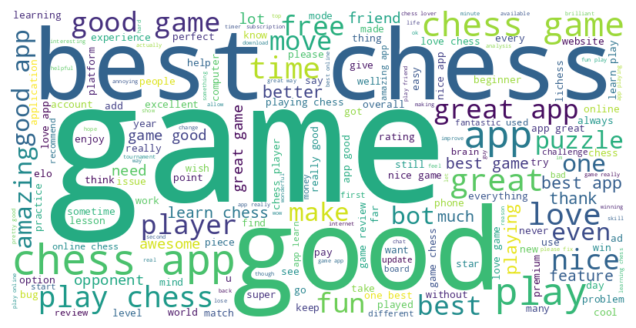

In [ ]:
# @title Postive wordcloud

import matplotlib.pyplot as plt
from wordcloud import WordCloud

reviews = df[df['sentiment'] == 'positive']['processed_content']
positive_text = " ".join(reviews)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)

plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

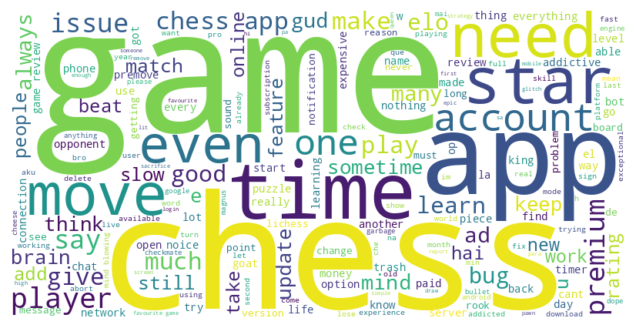

In [ ]:
# @title Neutral wordcloud

import matplotlib.pyplot as plt
from wordcloud import WordCloud

reviews = df[df['sentiment'] == 'neutral']['processed_content']
positive_text = " ".join(reviews)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)

plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

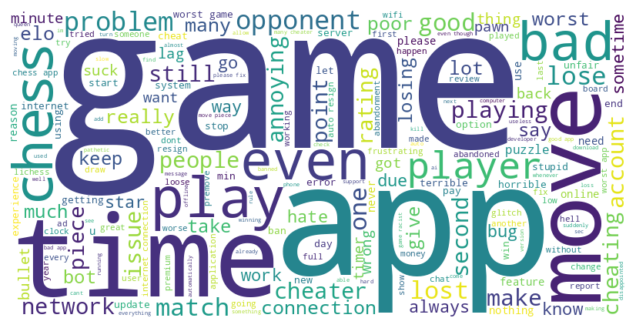

In [ ]:
# @title Negative wordcloud
import matplotlib.pyplot as plt
from wordcloud import WordCloud

reviews = df[df['sentiment'] == 'negative']['processed_content']
positive_text = " ".join(reviews)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)

plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Skema 1: SVM, TF-IDF, 80/20

## Data splitting 80/20 & Feature Extraction using TF-IDF

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

X_train, X_test, y_train, y_test = train_test_split(
    df['processed_content'], df['sentiment'], test_size=0.2, random_state=42
)

tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

## SVM Modelling

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

svm_model = SVC(kernel='linear')
svm_model.fit(X_train_tfidf, y_train)

svm_predictions_train = svm_model.predict(X_train_tfidf)
svm_predictions = svm_model.predict(X_test_tfidf)

svm_accuracy_train = accuracy_score(y_train, svm_predictions_train)
svm_accuracy = accuracy_score(y_test, svm_predictions)

print("Training set report:")
print(classification_report(y_test, svm_predictions))

print("Testing set report:")
print(classification_report(y_test, svm_predictions))

print(f"SVM train Accuracy: {svm_accuracy_train}")
print(f"SVM test Accuracy: {svm_accuracy}")


Training set report:
              precision    recall  f1-score   support

    negative       0.88      0.73      0.80       446
     neutral       0.84      0.92      0.88       576
    positive       0.95      0.96      0.96      2163

    accuracy                           0.92      3185
   macro avg       0.89      0.87      0.88      3185
weighted avg       0.92      0.92      0.92      3185

Testing set report:
              precision    recall  f1-score   support

    negative       0.88      0.73      0.80       446
     neutral       0.84      0.92      0.88       576
    positive       0.95      0.96      0.96      2163

    accuracy                           0.92      3185
   macro avg       0.89      0.87      0.88      3185
weighted avg       0.92      0.92      0.92      3185

SVM train Accuracy: 0.971978021978022
SVM test Accuracy: 0.9224489795918367


# Skema 2: Random Forest, TF-IDF, 80/20

Menggunakan hasil splitting dan feature extraction dari skema sebelumnya



## Random Forest Modelling

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_tfidf, y_train)

rf_predictions_train = rf_model.predict(X_train_tfidf)
rf_predictions = rf_model.predict(X_test_tfidf)

rf_accuracy_train = accuracy_score(y_train, rf_predictions_train)
rf_accuracy = accuracy_score(y_test, rf_predictions)

print("Training set report:")
print(classification_report(y_train, rf_predictions_train))

print("Testing set report:")
print(classification_report(y_test, rf_predictions))

print(f"Random Forest train Accuracy: {rf_accuracy_train}")
print(f"Random Forest test Accuracy: {rf_accuracy}")

Training set report:
              precision    recall  f1-score   support

    negative       1.00      1.00      1.00      1589
     neutral       0.99      1.00      1.00      2213
    positive       1.00      1.00      1.00      8938

    accuracy                           1.00     12740
   macro avg       1.00      1.00      1.00     12740
weighted avg       1.00      1.00      1.00     12740

Testing set report:
              precision    recall  f1-score   support

    negative       0.91      0.55      0.68       446
     neutral       0.83      0.83      0.83       576
    positive       0.90      0.97      0.93      2163

    accuracy                           0.89      3185
   macro avg       0.88      0.78      0.81      3185
weighted avg       0.89      0.89      0.88      3185

Random Forest train Accuracy: 0.9984301412872841
Random Forest test Accuracy: 0.8850863422291994


# Skema 3: Logistic Regression, n-gram, 80/20

## Data splitting 80/20 & Feature Extraction using n-gram

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(
    df['processed_content'], df['sentimentInt'], test_size=0.2, random_state=42
)

vectorizer = CountVectorizer(ngram_range=(1, 2))
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)


## Logistic Regression Modelling

In [ ]:
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_vec, y_train)

lr_predictions_train = lr_model.predict(X_train_vec)
lr_predictions = lr_model.predict(X_test_vec)

lr_accuracy_train = accuracy_score(y_train, lr_predictions_train)
lr_accuracy = accuracy_score(y_test, lr_predictions)

print("Training set report:")
print(classification_report(y_train, lr_predictions_train))

print("Testing set report:")
print(classification_report(y_test, lr_predictions))

print(f"Logistic Regression train Accuracy: {lr_accuracy_train}")
print(f"Logistic Regression test Accuracy: {lr_accuracy}")

Training set report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1589
           1       0.97      1.00      0.98      2213
           2       1.00      1.00      1.00      8938

    accuracy                           0.99     12740
   macro avg       0.99      0.99      0.99     12740
weighted avg       0.99      0.99      0.99     12740

Testing set report:
              precision    recall  f1-score   support

           0       0.91      0.67      0.77       446
           1       0.79      0.95      0.86       576
           2       0.96      0.96      0.96      2163

    accuracy                           0.92      3185
   macro avg       0.88      0.86      0.86      3185
weighted avg       0.92      0.92      0.91      3185

Logistic Regression train Accuracy: 0.9934850863422292
Logistic Regression test Accuracy: 0.9161695447409733


# Skema 4: GRU (Deep Learning), n-gram, 80/20

Menggunakan hasil splitting dan feature extraction dari skema sebelumnya

## GRU Modelling

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_sequence_length = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_sequence_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_sequence_length)

model = Sequential()
model.add(Embedding(5000, 128, input_length=max_sequence_length))
model.add(GRU(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train_pad, y_train, epochs=4, batch_size=256, validation_data=(X_test_pad, y_test))

Epoch 1/4


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 215ms/step - accuracy: 0.6925 - loss: 0.8182 - val_accuracy: 0.7887 - val_loss: 0.5218
Epoch 2/4
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 234ms/step - accuracy: 0.8323 - loss: 0.4365 - val_accuracy: 0.8477 - val_loss: 0.4119
Epoch 3/4
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 236ms/step - accuracy: 0.9050 - loss: 0.2877 - val_accuracy: 0.8732 - val_loss: 0.3246
Epoch 4/4
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 205ms/step - accuracy: 0.9460 - loss: 0.2029 - val_accuracy: 0.8848 - val_loss: 0.3165


In [ ]:
loss, accuracy = model.evaluate(X_train_pad, y_train)
print(f"GRU Train set Loss: {loss:.4f}")
print(f"GRU Train set Accuracy: {accuracy:.4f}")

loss, accuracy = model.evaluate(X_test_pad, y_test)
print(f"GRU Test set Loss: {loss:.4f}")
print(f"GRU Test set Accuracy: {accuracy:.4f}")

399/399 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9513 - loss: 0.2043
GRU Train set Loss: 0.2114
GRU Train set Accuracy: 0.9483
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.8835 - loss: 0.3311
GRU Test set Loss: 0.3165
GRU Test set Accuracy: 0.8848


# Kesimpulan

Setelah melakukan pelatihan dan testing untuk ketiga skema, didapatkan hasil:

1. SVM, TF-IDF, 80/20
```
Train Accuracy: 0.97
Test Accuracy: 0.92
```
2. Random Forest, TF-IDF, 80/20
```
Train Accuracy: 0.99
Test Accuracy: 0.89
```
3. Logistic Regression, n-gram, 80/20
```
Train Accuracy: 0.99
Test Accuracy: 0.92
```
3. GRU, n-gram, 80/20
```
Train Accuracy: 0.95
Test Accuracy: 0.88
```

Peringkat berdasarkan akurasi Testing dan training:
1. Logistic Regression, n-gram, 80/20 👑
2. SVM, TF-IDF, 80/20
3. Random Forest, TF-IDF, 80/20
4. GRU, n-gram, 80/20

# Live Model Inference / Testing (Logistic Regression)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import ipywidgets as widgets
from IPython.display import display, clear_output

text_input = widgets.Text(
    value='',
    placeholder='Enter text to predict',
    description='Text:',
    disabled=False
)
predict_button = widgets.Button(description="Predict")
exit_button = widgets.Button(description="Exit")
output = widgets.Output()


def on_predict_button_clicked(b):
    with output:
        clear_output()
        user_text = text_input.value
        if user_text.lower() == "exit":
            print("Exiting...")
            return

        processed_text = preprocess_text(user_text)
        text_vec = vectorizer.transform([processed_text])
        prediction = lr_model.predict(text_vec)[0]

        if prediction == 2:
            sentiment = 'positive'
        elif prediction == 1:
            sentiment = 'neutral'
        else:
            sentiment = 'negative'

        print(f"Predicted sentiment: {sentiment}")


predict_button.on_click(on_predict_button_clicked)


def on_exit_button_clicked(b):
    with output:
        clear_output()
        print("Exiting...")


exit_button.on_click(on_exit_button_clicked)

display(text_input, predict_button, exit_button, output)

Text(value='', description='Text:', placeholder='Enter text to predict')

Button(description='Predict', style=ButtonStyle())

Button(description='Exit', style=ButtonStyle())

Output()

In [ ]:
!pip install pipreqs
!pipreqs

INFO: Not scanning for jupyter notebooks.
INFO: Successfully saved requirements file in /content/requirements.txt
